# vnCDR sketch with Qiskit


This notebook shows the skeleton for a working variable noise Clifford data regression (vnCDR) implementation for a given circuit. The vnCDR training set construction is completed using Qiskit. A single instance of a random quantum circuit is used to explore performance relative to Clifford data regression (CDR) and ZNE with various functional extrapolations. 

First, let’s review the vnCDR and CDR methods to remind ourselves of how these methods work and the elements necessary. vnCDR is the more general setting and is also expected to provide better mitigated results on average, so we will focus on the formalism for this method when presenting the necessary steps. 

## vnCDR 
vnCDR is a data driven error mitigation method. That means data from many quantum circuits is used to mitigate the effect of noise produced by one circuit of interest. vnCDR uses data from circuits which are classically simulable evaluated both classically (using a simulator) and on a real device at various levels of hardware noise. This data set is then used to train an ansatz mapping the noisy to exact data. The trained ansatz is used to mitigate the effect of the noise on the circuit of interest evaluated at different hardware noise scale factors. 

More formally, let $U$ be a quantum circuit which we are interested in, $|0 \rangle$ its initial state, and $X$ an observable of interest. We want to estimate the expectation value $\mu = \langle 0|U^{+} X U |0 \rangle$ from measurements on a noisy quantum device. We can mitigate the effect of noise using the following procedure:

- (Clifford data) Choose a set of circuits $\mathcal{S} = \{V_i\}_{i=1}^m$ based on $U$ which will be used to form the training set $\mathcal{T}$ in step 3. The circuits in $\mathcal{S}$ must be efficient to simulate classically, which is ensured by constructing them primarily from Clifford gates. The number of non-Cliffords used is denoted by $N$. Note that $N$ is assumed to be a constant parameter here, so the simulations are classically tractable. 

    
- (Noise data) Choose a set of noise scale factors $\mathcal{C}=\{\lambda_0,\lambda_1,\dots,\lambda_n\}$ where $1 = \lambda_0 < \lambda_1 < \dots < \lambda_n$ which will be used to form the training set $\mathcal{T}$ in step 3. If the noise is characterized by a parameter $\epsilon$ then running the device with noise level $\lambda_j$ means the new parameter is $c_j\epsilon$.
    
- (Training set)  For each of the $m$ circuits $V_i$ in $\mathcal{S}$ and $n+1$ noise scale factors $\lambda_j\in \mathcal{C}$, produce an estimate of the observable expectation called $x_{i, j}$. Also, for each of the $m$ circuits compute $y_i = \langle 0|V_i^{+} X V_i |0 \rangle$ using a classical simulation. The training set $\mathcal{T}$ is then defined as $\mathcal{T} = \{(\vec{x}_i, y_i)\}$ where $\vec{x}_i = (x_{i,0},\dots,x_{i,n})$ is the vector of noisy estimates originating from the $i^\text{th}$ circuit.

- (Learning) Learn a function $f : \mathbb{R}^n \to \mathbb{R}$ that takes a set of noisy estimates at the $n+1$ different noise scale factors and outputs an estimate for the noise-free value. Specifically, we take the linear ansatz $g : \mathbb{R}^n \times \mathbb{R}^n \to \mathbb{R}$,

\begin{equation}
           g(\vec{x}; \vec{a}) = \vec{a}\cdot\vec{x}\
\end{equation}

We use least-squares regression on the dataset $\mathcal{T}$ to pick optimal parameters $\vec{a}^*$, i.e.,

\begin{align}
        \vec{a}^* = \underset{\vec{a}}{\text{argmin}} \sum_{i=1}^m \left(y_i - g(\vec{x}_i; \vec{a})\right)^2\,,
\end{align}
    
so that we expect $f(\vec{x}) = g(\vec{x}; \vec{a}^*)$ to output a good estimate for the noise-free expected value given a vector of noisy ones.
    
- (Correction) Use the estimate $\hat{\mu} = \vec{a}^*\cdot\vec{\mu}$, where $\vec{\mu} = (\hat{\mu}_0,\dots,\hat{\mu}_n)$ is comprised of the $n+1$ noisy expectations for the original circuit.

## CDR 

There are two important distinctions between CDR and vnCDR. CDR does not use multiple hardware noise scale factors. Therefore there is not a vector of data for each circuit in the training set just a singular point. This also leads to the trianed ansatz being different. In the case of CDR the training set consisting of the noisy evaluated trianing circuits and their exact values are used to train a linear ansatz: 
\begin{equation}
           g(x; a, b) = ax + c.
\end{equation}

## Important features

Two important considerations when implementing vnCDR and CDR are how hardware noise is increased and how the circuits in the training set are constructed from the circuit of interest. In this sketch we present the simplest form of training set construction and hardware noise level increase. 

To construct the trianing set of classically simulable circuits here we randomly select a certain number of the non-Clifford gates in our circuit of interest and project them to their nearest Clifford gate, leaving $N$ non-Cliffords. This process is repeated $M$ times, giving a training set of size $M$. 

Noise is incrased by inserting identites formed of repeated CNOT gates. This is done using the unitary folding method provided in the mitiq package. 

The perforance of the mitigation is expected to converge with the number of non-Clifford gates in the training set circuits ($N$) and the number of circuits in the training set ($M$).



## Imports

In [92]:
from qiskit import execute, QuantumCircuit, QuantumRegister, IBMQ, Aer, compiler
from qiskit.circuit.random import random_circuit
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import scipy.sparse as scs
from typing import Callable, Optional
from functools import wraps
from mitiq._typing import QPROGRAM
import numpy as np
from sklearn import linear_model
from operator import itemgetter
from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import Reset
from qiskit.circuit.library.standard_gates import (IGate, U1Gate, U2Gate, U3Gate, XGate,
                                                   YGate, ZGate, HGate, SGate, SdgGate, TGate,
                                                   TdgGate, RXGate, RYGate, RZGate, CXGate,
                                                   CYGate, CZGate, CHGate, CRZGate, CU1Gate,
                                                   CU3Gate, SwapGate, RZZGate,
                                                   CCXGate, CSwapGate)
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
import qiskit.providers.aer.noise as aern
from math import e
from qiskit.circuit.exceptions import CircuitError
from qiskit.util import deprecate_arguments
import random
from mitiq.zne.scaling import fold_gates_at_random
from mitiq.zne.zne import execute_with_zne
from mitiq.zne.inference import LinearFactory, RichardsonFactory, PolyFactory, ExpFactory
from functools import partial


## Load IBMQ account

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='ift-csic')

C:\Users\Max\Anaconda3\envs\TNS\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


## Random Quantum Circuit
In order to test the performance of vnCDR and CDR we need a test case to run on. Random quantum circuits (RQC) are a good option to use due to their generality. Below is the code to construct random quantum circuits (in Qiskit) composed of U3 and CNOT gates, with no fixed CNOT gate structure.


In [183]:
def random_circuit(
    num_qubits: int, 
    depth: int, 
    max_operands: int=2, 
    measure: bool=True,        
    conditional: bool=False, 
    reset: bool=False, 
    seed: bool=None
)-> QPROGRAM:
    """Returns random qiskit quantum circuit object, used to test the code here is working properly.
    
    Args:
        num_qubits (int): number of quantum wires
        depth (int): layers of operations (i.e. critical path length)
        max_operands (int): maximum operands of each gate (between 1 and 3)
        measure (bool): if True, measure all qubits at the end
        conditional (bool): if True, insert middle measurements and conditionals
        reset (bool): if True, insert middle resets
        seed (int): sets random seed (optional)

    Returns:
        qc (QPROGRAM): constructed circuit
    
    """
    
    if max_operands < 1 or max_operands > 3:
        raise CircuitError("max_operands must be between 1 and 3")

    one_q_ops = [ U3Gate]
    one_param = []
    two_param = []
    three_param = [U3Gate]
    two_q_ops = [CXGate]
    three_q_ops = []

    qr = QuantumRegister(num_qubits, 'q')
    qc = QuantumCircuit(num_qubits)

    if measure or conditional:
        cr = ClassicalRegister(num_qubits, 'c')
        qc.add_register(cr)

    if reset:
        one_q_ops += [Reset]

    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng = np.random.default_rng(seed)

    # apply arbitrary random operations at every depth
    for _ in range(depth):
        # choose either 1, 2, or 3 qubits for the operation
        remaining_qubits = list(range(num_qubits))
        while remaining_qubits:
            max_possible_operands = min(len(remaining_qubits), max_operands)
            num_operands = rng.choice(range(max_possible_operands)) + 1
            rng.shuffle(remaining_qubits)
            operands = remaining_qubits[:num_operands]
            remaining_qubits = [q for q in remaining_qubits if q not in operands]
            if num_operands == 1:
                operation = rng.choice(one_q_ops)
            elif num_operands == 2:
                operation = rng.choice(two_q_ops)
            elif num_operands == 3:
                operation = rng.choice(three_q_ops)
            if operation in one_param:
                num_angles = 1
            elif operation in two_param:
                num_angles = 2
            elif operation in three_param:
                num_angles = 3
            else:
                num_angles = 0
            angles = [rng.uniform(0, 2 * np.pi) for x in range(num_angles)]
            register_operands = [qr[i] for i in operands]
            op = operation(*angles)

            # with some low probability, condition on classical bit values
            if conditional and rng.choice(range(10)) == 0:
                value = rng.integers(0, np.power(2, num_qubits))
                op.condition = (cr, value)

            qc.append(op, register_operands)

    if measure:
        qc.measure(qr, cr)

    return qc

## Functions used in CDR
Here we begin the code that is used in the CDR method. First up we have a function that takes any Qiskit circuit and compiles it to minimise depth, as well as decomposing it into a gate set where the only non-Clifford gate is the Rz rotation gate.

In [190]:
def CircuitTranslation(
    circ: QPROGRAM
)-> QPROGRAM:
    """Decomposes qiskit circuit object into Rz, Rx(pi/2) (sx), X and CNOT gates. 
    
    Args:
        circ: original circuit of interest assumed to be qiskit circuit object.
        
    Returns: 
        circ_new: new circuite compiled and decomposed into the above gate set.
    """
    # this decomposes the circuit into u3 and cnot gates:
    circ = compiler.transpile(circ, basis_gates = ['sx','rz','cx', 'x'], optimization_level=3)
    #print(circ.draw())
    # now for each U3(theta, phi, lambda), this can be converted into Rz(phi+pi)Rx(pi/2)Rz(theta+pi)Rx(pi/2)Rz(lambda)
    try:
        circ_new = QuantumCircuit(len(circ.qubits),len(circ.clbits))
    except:
        circ_new = QuantumCircuit(len(circ.qubits))
    for i in range(len(circ.data)):
        # get information for the gate
        gate = circ.data[i][0]
        name = gate.name
        if name == 'cx':
            qubit = [circ.data[i][1][0].index, circ.data[i][1][1].index]
            parameters =[]
            circ_new.cx(qubit[0], qubit[1])
        if name =='rz':
            parameters = (float(gate.params[0]))%(2*np.pi)
            # leave out empty Rz gates:
            if parameters!=0:
                qubit = circ.data[i][1][0].index
                circ_new.rz(parameters, qubit)
        if name =='sx':
            parameters = np.pi/2
            qubit = circ.data[i][1][0].index
            circ_new.rx(parameters, qubit)
        if name =='x':
            qubit = circ.data[i][1][0].index
            circ_new.x(qubit)
        elif name =='measure':
            qubit = circ.data[i][1][0].index
            cbit = circ.data[i][2][0].index
            circ_new.measure(qubit, cbit) 
    return(circ_new)

It should be noted that the gates that are involved in this decomposition are soon to be made the basis gate set for all IBM computers. Lets have a look at the circuits we have constructed and how the decomposition affects our circuit.

In [348]:
num_qubits = 4
depth = 8
circuit = random_circuit(num_qubits, depth, measure = True, seed=0)
circuit.draw()

┌───┐                                 ┌───┐ ┌──────────────────────────┐ »
q_0: ┤ X ├─────────────────────────────────┤ X ├─┤ U3(1.1037,5.4235,3.4021) ├─»
     └─┬─┘┌──────────────────────────┐┌───┐└─┬─┘ ├──────────────────────────┤ »
q_1: ──┼──┤ U3(0.10385,5.1099,5.735) ├┤ X ├──┼───┤ U3(3.8666,2.4107,6.2657) ├─»
       │  └──────────────────────────┘└─┬─┘  │   ├─────────────────────────┬┘ »
q_2: ──■────────────────────────────────■────┼───┤ U3(6.1628,4.3074,4.087) ├──»
          ┌──────────────────────────┐       │  ┌┴─────────────────────────┴─┐»
q_3: ─────┤ U3(3.8116,4.5836,3.4157) ├───────■──┤ U3(0.17794,0.78089,4.2137) ├»
          └──────────────────────────┘          └────────────────────────────┘»
c: 4/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«     ┌──────────────────────────┐                                 »
«q_0: ┤ U3(4.5332,3.3009,1.9493) ├──────────────────────────────■──»
«     └──────────┬───┬───────────┘┌──────────────────────────┐  │  »
«q_1: ───────────┤ X ├────────────┤ U3(5.5938,1.4273,3.9156) ├──┼──»
«                └─┬─┘            ├──────────────────────────┤  │  »
«q_2: ─────────────■──────────────┤ U3(2.0224,3.7341,2.1232) ├──┼──»
«     ┌──────────────────────────┐└──────────────────────────┘┌─┴─┐»
«q_3: ┤ U3(3.0526,5.5888,5.8688) ├────────────────────────────┤ X ├»
«     └──────────────────────────┘                            └───┘»
«c: 4/═════════════════════════════════════════════════════════════»
«                                                                  »
«     ┌───────────────────────────┐                                       ┌─┐»
«q_0: ┤ U3(0.94423,2.8296,5.0035) ├───────────────────────────────■────■──┤M├»
«     ├───────────────────────────┤┌───────────────────────────┐  │  ┌─┴─┐└╥┘»
«q_1: ┤ U3(0.32686,2.5419,1.2473) ├┤ U3(5.9195,2.2941,0.66285) ├──┼──┤ X ├─╫─»
«     └┬─────────────────────────┬┘└───────────────────────────┘┌─┴─┐├───┤ ║ »
«q_2: ─┤ U3(4.9455,1.504,5.5071) ├──────────────────────────────┤ X ├┤ X ├─╫─»
«     ┌┴─────────────────────────┴┐ ┌─────────────────────────┐ └───┘└─┬─┘ ║ »
«q_3: ┤ U3(0.57022,3.6463,1.8768) ├─┤ U3(2.767,5.9979,3.1409) ├────────■───╫─»
«     └───────────────────────────┘ └─────────────────────────┘            ║ »
«c: 4/═════════════════════════════════════════════════════════════════════╩═»
«                                                                          0 »
«              
«q_0: ─────────
«     ┌─┐      
«q_1: ┤M├──────
«     └╥┘┌─┐   
«q_2: ─╫─┤M├───
«      ║ └╥┘┌─┐
«q_3: ─╫──╫─┤M├
«      ║  ║ └╥┘
«c: 4/═╩══╩══╩═
«      1  2  3

In [349]:
circuit_new = CircuitTranslation(circuit)
circuit_new.draw()

┌───┐      ┌──────────┐  ┌─────────┐  ┌────────────┐»
q_0: ──────────────────┤ X ├──────┤ RZ(3π/2) ├──┤ RX(π/2) ├──┤ RZ(1.9061) ├»
     ┌────────────┐    └─┬─┘      ├─────────┬┘ ┌┴─────────┴─┐└┬─────────┬─┘»
q_1: ┤ RZ(2.9451) ├──────┼────────┤ RX(π/2) ├──┤ RZ(5.5425) ├─┤ RX(π/2) ├──»
     └────────────┘      │       ┌┴─────────┴─┐├───────────┬┘ ├─────────┤  »
q_2: ────────────────────■───────┤ RZ(5.6578) ├┤ RZ(1.938) ├──┤ RX(π/2) ├──»
                   ┌────────────┐└┬─────────┬─┘├───────────┤  ├─────────┤  »
q_3: ──────────────┤ RZ(4.6403) ├─┤ RX(π/2) ├──┤ RZ(4.975) ├──┤ RX(π/2) ├──»
                   └────────────┘ └─────────┘  └───────────┘  └─────────┘  »
c: 4/══════════════════════════════════════════════════════════════════════»
                                                                           »
«     ┌─────────────┐┌─────────┐  ┌───────┐   ┌─────────┐ ┌────────────┐»
«q_0: ┤ RZ(0.11379) ├┤ RX(π/2) ├──┤ RZ(π) ├───┤ RX(π/2) ├─┤ RZ(6.1694) ├»
«     └┬────────────┤└─────────┘  └───────┘   └─────────┘ └┬──────────┬┘»
«q_1: ─┤ RZ(4.6529) ├──────────────────────────────■───────┤ RZ(3π/2) ├─»
«      └─┬───────┬──┘┌─────────┐┌────────────┐   ┌─┴─┐   ┌─┴──────────┴┐»
«q_2: ───┤ RZ(π) ├───┤ RX(π/2) ├┤ RZ(1.2036) ├───┤ X ├───┤ RZ(0.60523) ├»
«      ┌─┴───────┴──┐└─────────┘└────────────┘   └───┘   └─────────────┘»
«q_3: ─┤ RZ(3.7654) ├───────────────────────────────────────────────────»
«      └────────────┘                                                   »
«c: 4/══════════════════════════════════════════════════════════════════»
«                                                                       »
«                       ┌──────────┐  ┌─────────┐┌────────────┐┌─────────┐»
«q_0: ─────────────■────┤ RZ(3π/2) ├──┤ RX(π/2) ├┤ RZ(4.8399) ├┤ RX(π/2) ├»
«     ┌─────────┐  │   ┌┴──────────┴┐ ├─────────┤└─┬───────┬──┘└─────────┘»
«q_1: ┤ RX(π/2) ├──┼───┤ RZ(6.1628) ├─┤ RX(π/2) ├──┤ RZ(π) ├────────■─────»
«     ├─────────┤  │   └┬──────────┬┘ ├─────────┤ ┌┴───────┴┐     ┌─┴─┐   »
«q_2: ┤ RX(π/2) ├──┼────┤ RZ(3π/2) ├──┤ RX(π/2) ├─┤ RZ(π/2) ├─────┤ X ├───»
«     └─────────┘┌─┴─┐┌─┴──────────┴─┐├─────────┤ ├─────────┴┐ ┌──┴───┴──┐»
«q_3: ───────────┤ X ├┤ RZ(0.018675) ├┤ RX(π/2) ├─┤ RZ(3π/2) ├─┤ RX(π/2) ├»
«                └───┘└──────────────┘└─────────┘ └──────────┘ └─────────┘»
«c: 4/════════════════════════════════════════════════════════════════════»
«                                                                         »
«       ┌───────┐                   ┌────────────┐┌─────────┐┌───────────┐ »
«q_0: ──┤ RZ(π) ├────────────────■──┤ RZ(3.7279) ├┤ RX(π/2) ├┤ RZ(5.339) ├─»
«     ┌─┴───────┴──┐┌─────────┐  │  ├───────────┬┘├─────────┤├───────────┴┐»
«q_1: ┤ RZ(1.4643) ├┤ RX(π/2) ├──┼──┤ RZ(5.246) ├─┤ RX(π/2) ├┤ RZ(6.1576) ├»
«     ├────────────┤├─────────┤  │  ├───────────┴┐├─────────┤├────────────┤»
«q_2: ┤ RZ(4.5009) ├┤ RX(π/2) ├──┼──┤ RZ(4.8947) ├┤ RX(π/2) ├┤ RZ(1.2751) ├»
«     └┬─────────┬─┘└─────────┘┌─┴─┐├────────────┤├─────────┤├────────────┤»
«q_3: ─┤ RZ(π/2) ├─────────────┤ X ├┤ RZ(4.4507) ├┤ RX(π/2) ├┤ RZ(5.8928) ├»
«      └─────────┘             └───┘└────────────┘└─────────┘└────────────┘»
«c: 4/═════════════════════════════════════════════════════════════════════»
«                                                                          »
«     ┌─────────┐┌────────────┐          ┌─┐         
«q_0: ┤ RX(π/2) ├┤ RZ(2.8296) ├──■────■──┤M├─────────
«     └─────────┘└────────────┘  │  ┌─┴─┐└╥┘┌─┐      
«q_1: ───────────────────────────┼──┤ X ├─╫─┤M├──────
«                              ┌─┴─┐├───┤ ║ └╥┘┌─┐   
«q_2: ─────────────────────────┤ X ├┤ X ├─╫──╫─┤M├───
«     ┌─────────┐┌────────────┐└───┘└─┬─┘ ║  ║ └╥┘┌─┐
«q_3: ┤ RX(π/2) ├┤ RZ(4.9823) ├───────■───╫──╫──╫─┤M├
«     └─────────┘└────────────┘           ║  ║  ║ └╥┘
«c: 4/════════════════════════════════════╩══╩══╩══╩═
«                                         0  1  2  3

How does the decomposition change the depth?

In [350]:
print('old depth', circuit.depth())
print('new depth', circuit_new.depth())


old depth 9
new depth 24


The decomposition has increased the depth by some amount. This means that when implementing the circuit on a real device or noisy simulator the raw data from the decomposed circuit is likely to be worse than that from the original.

The next function takes a Qiskit circuit and extracts the information stored in the circuit, returning that information as an array. This makes many necessary steps in the CDR methods easier to implement, like completing gate substitutions for example.

In [22]:
def CircToArray(
    circ: QPROGRAM
)-> list:
    '''Function to return the order of gates, their names and paramters in a more managable data structure than a Qiskit
    quantum circuit.
    
    Args:
        circ: Qiskit circuits (deomposed).
        
    Returns:
        data: np.array([order], [names], [parameters], [qubits], [cbits])
        where order is the order of the gates from 0 to depth, names are the names of the gates, parameters are the paramters 
        specifying the gates and qubits and cbits are the qubits and classical bits on which they act.
        qubits: number of qubits.
        clbits: number of classical bits.
    '''
    order=[]
    gates_list = []
    qubits_list = []
    cbit_list = []
    parameters_list = []
    qubits = len(circ.qubits)
    clbits = len(circ.clbits)
    #loop through and construct arrays:
    for i in range(len(circ.data)):
        order.append(i)
        gate = circ.data[i][0]
        name = gate.name
        if name == 'cx':
            qubit = [circ.data[i][1][0].index, circ.data[i][1][1].index]
            parameters =None
            gates_list.append(name)
            qubits_list.append(qubit)
            cbit_list.append(None)
            parameters_list.append(parameters)
        elif name =='rz':
            parameters = gate.params[0]
            gates_list.append(name)
            qubit = circ.data[i][1][0].index
            qubits_list.append(qubit)
            cbit_list.append(None)
            parameters_list.append(float(parameters)%(2*np.pi))
        elif name =='rx':
            parameters = np.pi/2
            gates_list.append('rx')
            qubit = circ.data[i][1][0].index
            qubits_list.append(qubit)
            cbit_list.append(None)
            parameters_list.append(parameters)
        elif name =='x':
            parameters = None
            gates_list.append(name)
            qubit = circ.data[i][1][0].index
            qubits_list.append(qubit)
            cbit_list.append(None)
            parameters_list.append(parameters)
        elif name =='measure':
            parameters = None
            gates_list.append(name)
            qubit = circ.data[i][1][0].index
            cbit = circ.data[i][2][0].index
            qubits_list.append(qubit)
            cbit_list.append(cbit)
            parameters_list.append(parameters)
    data = np.array([order, gates_list,  parameters_list, qubits_list, cbit_list])
    return data, qubits, clbits
        

We also need a function that takes this array and gives back a Qiskit quantum circuit, this function is below.

In [9]:
def ArrayToCirc(
    data: np.ndarray,
    qubits: int,
    clbits: int
) -> QPROGRAM:
    ''' Function that takes the data array containing all the circuit data and turns it into a quantum circuit.
    
    Args:
        data: array containing circuit data np.array([order], [names], [parameters], [qubits], [cbits]).
        qubits: number of qubits.
        clbits: number of classical bits.
        
    Returns:
        circ: Qiskit quantum circuit
    
    '''
    gates_list= data[1,:]
    parameters_list = data[2,:]
    qubits_list = data[3,:]
    cbit_list = data[4,:]
    circ = QuantumCircuit(qubits,clbits)
    for i in range(len(gates_list)):
        gate = gates_list[i]
        parameter = parameters_list[i]
        qubit = qubits_list[i]
        cbit = cbit_list[i]
        if gate =='rz':
            circ.rz(parameter, qubit)
        if gate=='rx':
            circ.rx(parameter, qubit)
        if gate=='cx':
            circ.cx(qubit[0], qubit[1])
        if gate=='x':
            circ.x(qubit)
        if gate=='measure':
            circ.measure(qubit, cbit)
    return(circ)
        

## Clifford based functions
Here are the functions that check if a gate in our circuit is a Clifford gate and then use this information to complete projections and construct a training set.

In [10]:
def CliffordChecker(
    ang: float
)-> bool:
    '''Function to check if a given angle is Clifford.
    
    Args:
        ang: rotation angle in the Rz gate.
        
    Returns:
        bool: True / False for Clifford or not. 
    '''
    cliff_angs = [np.pi/2, np.pi, np.pi*3/2, 2*np.pi]
    diff_list=[]
    for cliff_ang in cliff_angs:
        diff_list.append(abs(abs(ang)-cliff_ang)%(2*np.pi))
    if any(np.array(diff_list)<=10**(-8)) == True:
        return True
    else:
        return False
    
# Vectorize function so it can take arrays of angles as its input.
CliffordChecker = np.vectorize(CliffordChecker)

In [11]:
def ClosestClifford(
    ang: float
)-> float:
    '''Function to take angle and return the nearest Clifford angle note the usage of this function is vectorized
    so it takes and returns arrays.
    
    Args:
        ang: angle in Rz gate.
        
    Returns:
        Clifford angle: closest clifford angle.
    '''
    cliff_angs = [np.pi/2, np.pi, np.pi*3/2, 2*np.pi]
    diff_list=[]
    for cliff_ang in cliff_angs:
        diff_list.append(abs(e**(-1j*ang)-e**(-1j*cliff_ang)))
    min_1 = min(diff_list)
    # need to check that there are not two min values in list
    diff_list_copy = diff_list.copy()
    diff_list_copy.remove(min_1)
    min_2 = min(diff_list_copy)
    # if just one min value, return the corresponding nearest cliff.
    if abs(min_1-min_2) > 10**(-8):
        return (cliff_angs[diff_list.index(min(diff_list))])
    # if two min values (ie two cliff gates equidistant) randomly choose the cliff gate to return.
    else:
        index_list = [diff_list.index(min_1), diff_list_copy.index(min_2)]
        index = random.choice(index_list)
        return(cliff_angs[index])

# vectorize so function can take array of angles.
ClosestClifford = np.vectorize(ClosestClifford)

Below is the function that takes one circuit of interest and constructs a trianing set by randon projections. This means that a given number of the non-Clifford gates in the circuit are selected and projected to their closest Clifford gate leaving N non-Cliffords. This process is repeated, producing a set of randomly projected Clifford dominated circuits.

In [12]:
def TrainingCircuitsConstructor(
    data: np.ndarray,
    size: int ,
    N: int
)-> np.ndarray:
    """Function that takes the original circuit and creates a training set with a given number of non-cliffords and total size.
    
    Args:
        data: data of the circuit of interst.
        size: number of Clifford projected circuits to return (size of training set).
        N: Number of non-Clifford gates to leave in each ciruit in the trianing set.
    
    Returns:
        circ_data: list of data arrays for projected circuits.
    """
    circ_data=[]
    mask_rz = data[1,:] == 'rz'
    rz_circ_data = data[:,mask_rz]
    mask_not_rz = data[1,:] != 'rz'
    not_rz_circ_data = data[:,mask_not_rz]
    mask_non_cliff = CliffordChecker(rz_circ_data[2,:]) == False
    rz_non_cliff = rz_circ_data[:,mask_non_cliff]
    mask_cliff = CliffordChecker(rz_circ_data[2,:]) == True
    rz_cliff = rz_circ_data[:,mask_cliff]
    tot_n_non_cliff = len(rz_non_cliff[0])
    #print(tot_n_non_cliff)
    all_cliff = np.column_stack((not_rz_circ_data, rz_cliff))
    #print(rz_non_cliff)
    for s in range(size):
        rz_non_cliff_copy = rz_non_cliff.copy()
        random_columns = random.sample(np.arange(0,tot_n_non_cliff,1).tolist(),tot_n_non_cliff-N)
        rand_rz_non_cliff_proj = rz_non_cliff_copy[:,random_columns]
        #print(rz_non_cliff_copy)
        rz_non_cliff_copy=np.delete(rz_non_cliff_copy, random_columns, axis=1)
        rand_rz_non_cliff_proj[2,:] = ClosestClifford(rand_rz_non_cliff_proj[2,:])
        #print(rz_non_cliff_copy)
        new_circ = np.column_stack((all_cliff, rand_rz_non_cliff_proj))
        new_circ = np.column_stack((new_circ, rz_non_cliff_copy))
        i = np.argsort(new_circ[0,:])
        final = new_circ[:,i]
        circ_data.append(final)
    return(circ_data)

There are many different ways to select the non-Clifford gates to replace with Cliffords. Selecting them at random does not in general form a good set of circuits that accurately reflect the effect of noise on the circuit of interest. A better method to choose the gates to replace considers the closeness of gates to Clifford gates when executing the replacement. Rotation gates that are closer to Cliffords are more likely to be replaced according to some probability distribution. 

This we define as probabilistic projection and has been observed to result in better mitigations in most cases. Below is the code used to construct the training sets in the probabilistic manner described.

In [13]:
def TrainingCircuitsConstructorProbProject(
    data: np.ndarray,
    size: int ,
    N: int,
    sigma: float
)-> np.ndarray:
    """Function that takes the original circuit and creates a training set with a given number of non-cliffords and total size.
    The Clifford gates to replace are chosen probabilistically according to the probabilitiy distribution:
    
                            Prob_project = exp(-(dist/sigma)^2)
    
    Where dist is the frobenius norm from powers of the S gate and the non-Clifford gate in consideration. The gate with which
    to replace the gate of question in is also replaced according to this probability distribution.
    
    Args:
        data: data of the circuit of interst.
        size: number of Clifford projected circuits to return (size of training set).
        N: Number of non-Clifford gates to leave in each ciruit in the trianing set.
        sigma: the width of the probability distribution.
    
    Returns:
        circ_data: list of data arrays for projected circuits.
    """
    circ_data=[]
    mask_rz = data[1,:] == 'rz'
    rz_circ_data = data[:,mask_rz]
    mask_not_rz = data[1,:] != 'rz'
    not_rz_circ_data = data[:,mask_not_rz]
    mask_non_cliff = CliffordChecker(rz_circ_data[2,:]) == False
    rz_non_cliff = rz_circ_data[:,mask_non_cliff]
    mask_cliff = CliffordChecker(rz_circ_data[2,:]) == True
    rz_cliff = rz_circ_data[:,mask_cliff]
    tot_n_non_cliff = len(rz_non_cliff[0])
    #print(tot_n_non_cliff)
    all_cliff = np.column_stack((not_rz_circ_data, rz_cliff))
    for s in range(size):
        rz_non_cliff_copy = rz_non_cliff.copy()
        non_cliff_angles = rz_non_cliff_copy[2]
        # form a probability distribution: 
        probabilities = ProbabilityDist(non_cliff_angles, sigma)
        prob_flip_gate = [k/sum(probabilities) for k in probabilities]
        random_columns = np.random.choice(np.arange(0,tot_n_non_cliff,1).tolist(), tot_n_non_cliff-N, replace=False,
                                            p=prob_flip_gate)
        #Now we have the positions of the non-Cliffords to change we need to change them probabilistically as well:
        rand_rz_non_cliff_proj = rz_non_cliff_copy[:,random_columns]
        #print(rz_non_cliff_copy)
        rz_non_cliff_copy=np.delete(rz_non_cliff_copy, random_columns, axis=1)
        rand_rz_non_cliff_proj[2,:] = ProbabilisticClifford(rand_rz_non_cliff_proj[2,:], sigma)
        #print(rz_non_cliff_copy)
        new_circ = np.column_stack((all_cliff, rand_rz_non_cliff_proj))
        new_circ = np.column_stack((new_circ, rz_non_cliff_copy))
        i = np.argsort(new_circ[0,:])
        final = new_circ[:,i]
        circ_data.append(final)
    return(circ_data)

In [14]:
def ProbabilityDist(
    angle: float,
    sigma: float
)-> float:
    """Function to return probability disribtuion based on distance from angles to Clifford gates.
    
    Args:
        angle: angle to form probability distribution. 
    
    Returns:
        discrete value of probability distribution calucalted from Prob_project = exp(-(dist/sigma)^2) where dist = sum(dists)
        is the sum of distances from each Clifford gate.
    """
    S = np.array([[1,0.0],[0.0,1j]])
    Rz = np.array([[1,0.0],[0.0,np.exp(angle*1j)]])
    dists = []
    cliff_angs = [np.pi/2, np.pi, np.pi*3/2, 2*np.pi]
    for i in range(4):
        i+=1
        diff = np.linalg.norm(Rz - S**(i))
        dists.append(np.exp(-(diff/sigma)**2))
    return(sum(dists))

# vectorize so function can take array of angles.
ProbabilityDist = np.vectorize(ProbabilityDist)

In [15]:
def ProbabilisticClifford(
    ang: float,
    sigma: float
)-> float:
    '''Function to take angle and return the Clifford angle according to the probability distirbution:
                        
                        prob = exp(-(dist/sigma)^2)
                        
    where dist is the frobenius norm from the 4 clifford angles and the gate of interest. Note the usage of this function
    is vectorized so it takes and returns arrays.
    
    Args:
        ang: angle in Rz gate.
        sigma: width of probability distribution.
        
    Returns:
        Clifford angle: clifford angle to replace gate angle, calculated probabilistically.
    '''
    S = np.array([[1,0.0],[0.0,1j]])
    Rz = np.array([[1,0.0],[0.0,np.exp(ang*1j)]])
    cliff_angs = [np.pi/2, np.pi, np.pi*3/2, 2*np.pi]
    dists=[]
    for i in range(4):
        i+=1
        diff = np.linalg.norm(Rz - S**(i))
        dists.append(np.exp(-(diff/sigma)**2))
    prob_gate = [i/sum(dists) for i in dists]
    cliff_ang = np.random.choice(cliff_angs, 1, replace=False, p=prob_gate)
    return(cliff_ang)

# vectorize so function can take array of angles.
ProbabilisticClifford = np.vectorize(ProbabilisticClifford)

Now we have got the training circuits constructed lets define the way we increase the noise:

In [16]:
def NoiseIncrease(
    circ: QPROGRAM, 
    scale_factor: int
)-> QPROGRAM:
    '''Function to scale the noise in the same manner to all circuits - circuit of interest and circuits in trianing set.
    
    Args:
        circ: circuit object
        scale_factor: the scale factor with which to scale the noise level.
        
    Returns:
        folded_circ: the new circuit with increased noise.
    '''
    # Just going to put one example of noise increasing here, this needs to be generalised. 
    folded_circ = fold_gates_at_random( circ, scale_factor=scale_factor, fidelities={"single": 1.0,
                                       "CNOT": 0.99})
    return(folded_circ)

## Utility functions for Qiskit 
Here we define some functions that are important to extract the desired quantities from the Qiskit simulation/ real device data.

In [17]:
def binarize(
    decimal: float, 
    L: int
)-> float:
    """Converts a decimal number <=2**L to binary. It is used to make the qiskit convention and the usual 
    description of the basis of an L-spin system compatible.
    
    Args:
        decimal: Number in base 10 to be converted to binary.
        L: Total number of qubits in the system.
        
    Returns:
        Number described by the parameter 'decimal' in binary.
    """
    binario = np.zeros(L)
    bin = ''
    for i in range(L):
        binario[L - 1 - i] = decimal % 2
        decimal = decimal // 2
        bin = bin + str(binario.astype(int)[L - 1 - i])

    return bin[::-1]

In [54]:
def expected_value(
    Obs: np.ndarray,
    state: dict
)-> float:
    """Calculates the expected value of a diagonal observable.
    
    Args:
        Obs: Observable in the form of a diagonal matrix.
        state: Dictionary describing the state of the system on which the expected value of the observable is to
        be calculated.
        
    Returns:
        Expected value <state|Obs|state>.
    """
    obs = sum([Obs[i, i] * list(state.values())[i] for i in range(np.shape(Obs)[0])])
    return obs


In [55]:
def state_counts(
    counts: dict
)-> dict:
    """Expresses the result of the simulation in the usual way, that is, in the form of a dictionary whose values are
    the module squared of the components of the final state.
    
    Args:
        counts: Dictionary included in Qiskit result class that allows that allows to get the histogram
        data of an experiment.
        
    Returns:
        state: Dictionary whose keys are the base elements of the L qubit system and whose values are the
        modulus of the corresponding squared amplitudes.
    """
    L = len(list(counts)[0])
    basis = {i: binarize(i, L) for i in range(2 ** L)}
    counts_order = [0 for i in range(2 ** L)]
    for i in range(len(basis)):
        for j in range(len(counts)):
            if list(basis.values())[i] == list(counts)[j][::-1]:
                counts_order[i] = list(counts.values())[j]
    normalization = 0
    for i in range(2 ** L):
        normalization += counts_order[i]

    state = {list(basis.values())[i]: counts_order[i] / normalization for i in range(2 ** L)}
    return state



In [56]:
def Magnetization(
    j: float, 
    L: float
)-> sci.sparse.csc_matrix:
    """Generation of the local magnetization (sigma_z) operator.
    
    Args:
        j: Label of the qubit on which its magnetization is to be calculated.
        L: Total number of qubits in the system.
        
    Return:
        Hz: Magnetization operator for qubit j in matrix form
    """
    sigmaz = scs.csc_matrix([[1, 0], [0, -1]])
    Id = scs.identity(2,format='csc')
    Hz = scs.csc_matrix((2**L, 2**L))
    Hzj = Id
    if j == 0:
        Hzj = sigmaz
    for i in range(L - 1):
        if i < j - 1:
            Hzj = scs.kron(Hzj, Id, format='csc')
        elif i == j - 1:
            Hzj = scs.kron(Hzj, sigmaz, format='csc')
        elif j - 1 < i < L - 1:
            Hzj = scs.kron(Hzj, Id, format='csc')
    Hz = Hz + Hzj
    return Hz


## Execute and Simulate functions
Here we define the functions that execute a given circuit on a 'real' device (in this case we use a simulated device with a given noise model), and execute a circuit on a exact simulator. These two functions are then used to build the training set data, consisting of exact and noisy expectation values.

Here the executor takes any circuit and runs it on a simulation of the IBMQ Bogota computer, with a simulated noise model. The float that is returned is the expectation value of the $\sigma_{z}$ observable at some position. 


In [341]:
def executor(
    circ: QPROGRAM,
)-> float:
    '''
    Function to run my noisey circuits, being treated as real backend. Measures <sigma_z> on first qubit,
    assuming all qubits are measured.
    
    Args: 
        circ: quantum circuit to be evaluated.    
        noise_model: qiskit noise model to run with simulation.
        
    returns:
        <sigma_z>: returns the observable at the given position with simulated device noise.
    '''
    
    # extracting the basis gates:
    device = 'ibmq_bogota'
    try:
        real_device = provider.get_backend(device)
        coupling_map = real_device.configuration().coupling_map
        noise_model = aern.NoiseModel.from_backend(real_device)
        basis_gates = noise_model.basis_gates
    except:
        real_device = provider.get_backend(device)
        coupling_map = real_device.configuration().coupling_map
        noise_model = aern.NoiseModel.from_backend(real_device)
        basis_gates = noise_model.basis_gates
    
    # Create an empty noise model
    noise_model = NoiseModel()
    
    #add bit flip and phase flip:
    p_error = 0.05
    bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
    phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
    error_bpf = bit_flip.compose(phase_flip)
    
    # Add depolarizing error to all single qubit u1, u2, u3 gates
    error_dp = depolarizing_error(0.05, 1)
    error_2 = error_dp.compose(error_bpf)
    
    # add thermal relaxation error: 
    error_tr = thermal_relaxation_error(60*10**(-6),80*10**(-6), 0.1)
    
    #make 2 qubit error:
    error_2_qubit = error_2.tensor(error_2)
    error = error_dp.compose(error_tr)
    
    #readout error:
    error_ro = ReadoutError([[1 - 0.05, 0.05], [0.1, 1 - 0.1]])
    
    # construct noise model:
    noise_model.add_all_qubit_quantum_error(error_2_qubit, ['cx'])
    noise_model.add_all_qubit_quantum_error(error_2, ['rx', 'rz'])
    noise_model.add_all_qubit_readout_error(error_ro, ['measure'])
    
    position = 1
    qubits = len(circ.qubits)
    obs = Magnetization(position, qubits)
    job = execute(circ, Aer.get_backend('qasm_simulator'),
              optimization_level=0, shots=8192, noise_model=noise_model, 
                  basis_gates=basis_gates)
    result = job.result()
    counts = result.get_counts()
    counts = {k.replace(' ', ''): v for k, v in counts.items()}
    state = state_counts(counts)
    sigma_z = expected_value(obs, state)
    return(sigma_z)

The simulator function is the same as the executor but returns exact results (up to shot noise).

In [335]:
def simulator(
    circ: QPROGRAM, 
)-> float:
    '''Function to run my noisey circuits, being treated as real backend. Measures <sigma_z> on a given qubit specified
    by the position variable assuming all qubits are measured.
    
    Args: 
        circ: quantum circuit to be evaluated. 
        
    returns:
        <sigma_z>: returns the exact observable at the given position but includes shot noise.
    '''
    position = 1
    qubits = len(circ.qubits)

    obs = Magnetization(position, qubits)
    job = execute(circ, Aer.get_backend('qasm_simulator'),
              optimization_level=0, shots=8192)

    result = job.result()
    counts = result.get_counts()
    counts = {k.replace(' ', ''): v for k, v in counts.items()}
    state = state_counts(counts)
    sigma_z = expected_value(obs, state)

    return(sigma_z)

With these two functions the training set data can then be generated by passing the training circuits through the exector and simulator functions. Note that due to the currrent definition of these functions each observable will have its own training set used for correction. This means to correct each observable $M$ circuits will need to be evaluated classically and on the real device. In reality this might not be neccesary. One training set could be used to correct many observables (as long as the circuit of interest is not affected by their evaluation, ie many observables diagonal in the z basis could be corrected from the same training set potentially). 

However, in this tutorial we are only looking at one particular observable, $\sigma_{z}$ at some provided position, so the way the executor and simulator are defined here is sufficient.

In [198]:
def TrainingSetGenerator(
    circ: QPROGRAM, 
    scale_factors: list, 
    M: int, 
    N: int,
    sigma: float
)-> np.ndarray:
    '''Function that takes a circuit of interest and the position of sigma_z observable and paramters to construct the training
    set, returns an array of the training data.
    
    Args: 
        circ: circuit of interest.
        scale_factors: scale factors to increase the noise.
        M: size of training set. 
        N: number of non-Cliffords per circuit in training set.
        sigma: width of probability distribution used in probabilistic training set construction.
        
    Return:
        training_data: M by (scale_factors+1) array containing exact and noisy observables at different scale factors. 
    '''
    circ_data, qubits, clbits = CircToArray(circ)
    if sigma==None:
        training_circ_data = TrainingCircuitsConstructor(circ_data, M, N)
    else:
        training_circ_data = TrainingCircuitsConstructorProbProject(circ_data, M, N, sigma)
    training_data = np.zeros((M, 1+len(scale_factors)))
    for i in range(len(training_circ_data)):
        train_circ = ArrayToCirc(training_circ_data[i], qubits, clbits)
        # checking how many non-Cliffords:
        data, _, _ = CircToArray(train_circ)
        mask_rz = data[1,:] == 'rz'
        rz_circ_data = data[:,mask_rz]
        mask_not_rz = data[1,:] != 'rz'
        not_rz_circ_data = data[:,mask_not_rz]
        mask_non_cliff = CliffordChecker(rz_circ_data[2,:]) == False
        rz_non_cliff = rz_circ_data[:,mask_non_cliff]
        training_data[i,0] = simulator(train_circ)
        for s, scale_factor in enumerate(scale_factors):
            noise_inc_circ = NoiseIncrease(train_circ, scale_factor)
            training_data[i,s+1] = executor(noise_inc_circ)
    return(training_data)        

## Regression functions
Below we have the functions that take the training set produced above and fit it with the vnCDR and CDR ansatzes. The fitting is done using the package sklearn for ease of use, but this can be replaced if so desired.

In [199]:
def vnCDR_mitigate(
    train_data: np.ndarray, 
    circ_data: np.ndarray
)->float:
    '''Function that uses the training data to perform a regression and return the best fit variables the ansatz used is 
    a simple linear model. 
    
    Args: 
        train_data: Data from Clifford circuits used to train the model. 
        circ_data: Data from actual circuit of interest which the trained model is then used to mitigate.
        
    Returns:
        corrected: mitigated value caluclated using the provided training set.
    '''
    reg = linear_model.LinearRegression(fit_intercept=False)
    
    X_train = np.array(train_data[:,1:])
    y_train = np.array(train_data[:,0])
    X_test = circ_data
    X_test.reshape(1,-1)
    reg.fit(X_train, y_train)
    corr = reg.predict([X_test])
    return corr[0]

Note below only one noise level is used in the mitigation, as required for CDR.

In [200]:
def CDR_mitigate(
    train_data: np.ndarray, 
    circ_data: np.ndarray
)-> float:
    '''Function that uses the training data to perform a regression and return the best fit variables using oly one noise level.
    
    Args:
        train_data: Data from Clifford circuits used to train simple linear anstaz (only one noise level used here).
        circ_data: Data from actual circuit of interest which is mitigated by the trained model.
        
    Returns:
        corrected: mitigated observable.
    '''
    reg = linear_model.LinearRegression(fit_intercept=True)
    X_train = np.array(train_data[:,1]).reshape(-1,1)
    y_train = np.array(train_data[:,0]).reshape(-1,1)
    X_test = circ_data.reshape(1, -1)
    reg.fit(X_train, y_train)
    corr = reg.coef_[0]*circ_data+reg.intercept_[0]
    return corr[0]

Now all the functions have been defined we can generate the real data for the circuit of interest at various noise scale factors.

In [201]:
def circuit_data(
    circ: QPROGRAM,
    scale_factors:list
)-> np.ndarray:
    '''Function that takes a circuit of interest and observable position and returns the observable at scaled noise values.
    
    Args:
        circ: circuit of interest.
        scale_factors: list of factors with which to scale the noise.
        
    Returns:
        circ_data: array of observables at increasing noise strength.
    '''
    circ_data = np.zeros((len(scale_factors)))
    for s, scale_factor in enumerate(scale_factors):
        noise_inc_circ = NoiseIncrease(circ, scale_factor)
        circ_data[s] = executor(noise_inc_circ)
    return circ_data
    

In [317]:
def clifford_data_mitigation(
    circ: QPROGRAM, 
    scale_factors: list, 
    M: int, 
    N: int,
    sigma: float=None,
)-> list:
    '''Function that takes a circuit and scale factors and returns the vnCDR and CDR mitigations as well as the raw result.
    
    Args:
        circ: quantum circuit of interest. 
        position: position of sigma_z observable.
        scale_factors: scale factors with which to increase the noise.
        M: size of the training set used in CDR and vnCDR. 
        N: number of non-Clifford gates per training set.
        sigma: the width of the probability distribution for probabilistic projection (if None, random projection used).
        
    Returns:
        vnCDR_mit: result mitigated by vnCDR. 
        CDR_mit: result mitigated by CDR.
        circ_data: raw noisy result.
    '''
    training_data = TrainingSetGenerator(circ,scale_factors, M, N, sigma)
    circ_data = circuit_data(circ, scale_factors)
    vnCDR_mit = vnCDR_mitigate(training_data, circ_data)
    CDR_mit =CDR_mitigate(training_data, circ_data[0])
    return vnCDR_mit, CDR_mit, circ_data, training_data
    

In [203]:
def Abs_error(
    val_1: float, 
    val_2:float
)->float:
    '''Function to calculated the absolute error between two floats
    
    Args:
        val_1: noisy/ mitigated observable. 
        val_2: exact observable.
        
    Returns:
        absolute error.
    '''
    return abs(val_1-val_2)/abs(val_2)

Now having defined all these functions we can tie them together and compare the performance for the RQC constructed at the beginning of this notebook.

First lets define the parameters we will use, in order to do this we should check how many non-Clifford gates there are in our original decomposed circuit of interest:

In [204]:
def NumberNonCliffords(
    circuit: QPROGRAM
)-> float:
    '''Function to check how many non-Clifford gates are in a give circuit.
    
    Args: 
        circuit: some quantum circuit.
        
    Returns: 
        number of non-Clifford gates in the given circuit.
    '''
    data, _, _ = CircToArray(circuit)
    mask_rz = data[1,:] == 'rz'
    rz_circ_data = data[:,mask_rz]
    mask_not_rz = data[1,:] != 'rz'
    not_rz_circ_data = data[:,mask_not_rz]
    mask_non_cliff = CliffordChecker(rz_circ_data[2,:]) == False
    rz_non_cliff = rz_circ_data[:,mask_non_cliff]
    return(len(rz_non_cliff[0]))

We need to use a smaller number than the above result and lets just assume we are only interested in the $\sigma_{z}$ of the 1st qubit, so lets take the following:

In [389]:
print('Non Cliffords', NumberNonCliffords(circuit_new))

Non Cliffords 28


In [390]:
# fix parameters for CDR:
scale_factors = [1.0,2.0,3.0]
M=30
N=4

Now lets execute the vnCDR and CDR mitigation methods. Note this may take some time due to the construction of the training set.

In [391]:
print('Data regression underway')
vnCDR_mit, CDR_mit, noisy, training_data = clifford_data_mitigation(circuit_new, scale_factors,M,N)
print('Running exact simulation (with shot noise)')
exact = simulator(circuit_new)
print('Finished')

Data regression underway
Running exact simulation (with shot noise)
Finished


In [392]:
print('exact',exact)
print('noisy', noisy[0])
print('vnCDR mitigated', vnCDR_mit)
print('CDR mitigated', CDR_mit)

exact -0.240966796875
noisy 0.088134765625
vnCDR mitigated 0.008876531391648717
CDR mitigated 0.0046643019651806394


Lets have a look at the observables in the training set that are used to understand the noise. This is often an important step in investigating how effective the training set construction method is, and if the mitigation can be improved.

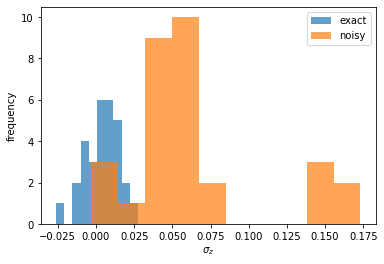

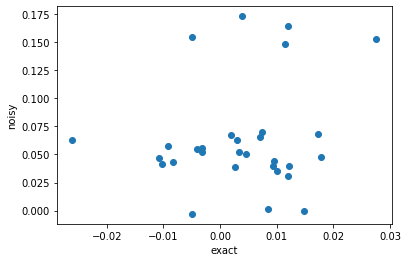

In [393]:
noise_level=1
exact_observables = training_data[:,0]
noise_1_observables = training_data[:,noise_level]
plt.figure(1)
plt.hist(exact_observables, bins=10, alpha=0.7, label = 'exact')
plt.hist(noise_1_observables, bins=10, alpha = 0.7, label = 'noisy')
plt.legend()
plt.xlabel(r'$\sigma_{z}$')
plt.ylabel('frequency')
plt.show()
plt.figure(2)
plt.scatter(exact_observables, noise_1_observables)
plt.xlabel('exact')
plt.ylabel('noisy')
plt.show()

In general a training set with a diverse range of both noisy and exact values is more effective and giving an accurate mitigation. These diverse training sets require more complex methods of construction that random projection.

What about the other training set construction method? How does this perform for the same training set size and number of non-Clifford gates? Well, it depends on the parameter $\sigma$, which governs the width of probability distribution used in the projections. 

One can think of $\sigma$ as the parameter that governs how random (or deterministic) the projections are. Generally, a balance between the two is best so we expect sigma values of around $0.8$ to work well. Let’s have a look:


In [394]:
print('Data regression underway')

# Now including sigma argument:

sigma = 0.5
vnCDR_mit, CDR_mit, noisy, training_data = clifford_data_mitigation(circuit_new, scale_factors,M,N, sigma)
print('Running exact simulation (with shot noise)')
exact = simulator(circuit_new)
print('Finished')

Data regression underway
Running exact simulation (with shot noise)
Finished


In [395]:
print('exact',exact)
print('noisy', noisy[0])
print('vnCDR mitigated', vnCDR_mit)
print('CDR mitigated', CDR_mit)

exact -0.23876953125
noisy 0.068359375
vnCDR mitigated -0.10358886122395962
CDR mitigated -0.12992350484260823


Once again lets have a look at the training set constructed with this method.

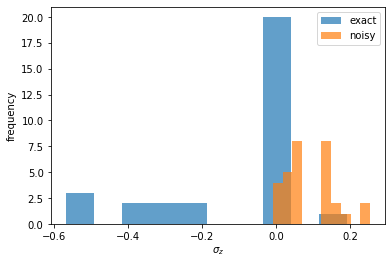

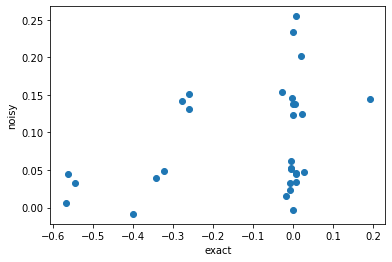

In [396]:
noise_level=1
exact_observables = training_data[:,0]
noise_1_observables = training_data[:,noise_level]
plt.figure(1)
plt.hist(exact_observables, bins=10, alpha=0.7, label = 'exact')
plt.hist(noise_1_observables, bins=10, alpha = 0.7, label = 'noisy')
plt.legend()
plt.xlabel(r'$\sigma_{z}$')
plt.ylabel('frequency')
plt.show()
plt.figure(2)
plt.scatter(exact_observables, noise_1_observables)
plt.xlabel('exact')
plt.ylabel('noisy')
plt.show()

We can also run ZNE with various fitting forms for a comparison:

In [397]:
print('ZNE underway')
# method: scale noise by 1 and 2, then extrapolate linearly to the zero noise limit.
linear_fac = LinearFactory(scale_factors=scale_factors[0:2])

# method: scale noise by 1, 2 and 3, then evaluate the Richardson extrapolation.
richardson_fac = RichardsonFactory(scale_factors=scale_factors[0:3])

# method: scale noise by 1, 2, 3, and 4, then extrapolate quadratically to the zero noise limit.
poly_fac = PolyFactory(scale_factors=scale_factors, order=2)

# method: scale noise by 1, 2, 3, and 4, then extrapolate exponentially to the zero noise limit.
exp_fac = ExpFactory(scale_factors=scale_factors)

lin_zne = linear_fac.run(circuit_new, executor, scale_noise=partial(fold_gates_at_random, fidelities={"single": 1.0,"CNOT": 0.99}))
rich_zne = richardson_fac.run(circuit_new, executor, scale_noise=partial(fold_gates_at_random, fidelities={"single": 1.0,"CNOT": 0.99}))
poly_zne = poly_fac.run(circuit_new, executor, scale_noise=partial(fold_gates_at_random, fidelities={"single": 1.0,"CNOT": 0.99}))
exp_zne = exp_fac.run(circuit_new, executor, scale_noise=partial(fold_gates_at_random, fidelities={"single": 1.0,"CNOT": 0.99}))
print('Zne finished')

ZNE underway
Zne finished


Finally lets compare the results:

In [398]:
print('Absolute errors:')
try:
    zne_lin = execute_with_zne(circuit_new, executor, factory=linear_fac)
    print('lin_zne error', Abs_error(zne_lin, exact))
except:
    zne_lin = None
try:
    zne_rich = execute_with_zne(circuit_new, executor, factory=richardson_fac)
    print('rich_zne error', Abs_error(zne_rich, exact))
except:
    zne_rich = None
try:
    zne_poly = execute_with_zne(circuit_new, executor, factory=poly_fac)
    print('poly_zne error', Abs_error(zne_poly, exact))
except:
    zne_poly = None
try:
    zne_exp = execute_with_zne(circuit_new, executor, factory=exp_fac)
    print('exp_zne error', Abs_error(zne_exp, exact))
except:
    zne_exp = None


print('vnCDR error', Abs_error(vnCDR_mit, exact))
print('CDR_mit error', Abs_error(CDR_mit, exact))
print('noisy error', Abs_error(noisy[0], exact))



Absolute errors:
lin_zne error 1.4468302658486707
rich_zne error 1.4713701431492847
poly_zne error 0.8312883435582802
exp_zne error 44155.311386396424
vnCDR error 0.5661554441990403
CDR_mit error 0.4558622946469087
noisy error 1.2862985685071575


C:\Users\Max\Anaconda3\envs\TNS\lib\site-packages\scipy\optimize\minpack.py:808: ExtrapolationWarning: The extrapolation fit may be ill-conditioned. Likely, more data points are necessary to fit the parameters of the model.
  category=OptimizeWarning)


Hopefully one can see that the results from Clifford based methods are superior. This may vary according to the noise model from the IBM computer, which does change. Lets explore how the noisy results are changing with increased noise level, this is always something important to look at to inform the best extrpolation method to use.

In [399]:
circuit_data_example = circuit_data(circuit_new, scale_factors)

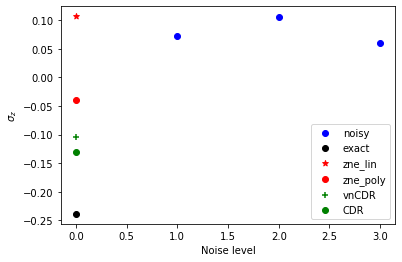

In [400]:
plt.figure(1)
plt.scatter(scale_factors, circuit_data_example, label = 'noisy', color = 'blue')
plt.scatter([0], [exact], label = 'exact', color = 'black')
plt.scatter([0], [zne_lin], label = 'zne_lin', color = 'red', marker = '*')
plt.scatter([0], [zne_poly], label = 'zne_poly', color = 'red', marker = 'o')
plt.scatter([0], [vnCDR_mit], label = 'vnCDR', color = 'green', marker = '+')
plt.scatter([0], [CDR_mit], label = 'CDR', color = 'green', marker = 'o')
plt.xlabel('Noise level')
plt.ylabel(r'$\sigma_{z}$')
plt.legend()
plt.show()

It is also important to explore convergence for the CDR and vnCDR methods, let have a look at how the accuracy of the solution changes with increasing training set size and number of non-Cliffords.

In [401]:
CDR_list = []
vnCDR_list = []
M_list=np.arange(4,M,1)
print('Data regression underway')
for M_1 in M_list:
    vnCDR_mit = vnCDR_mitigate(training_data[0:M_1], noisy)
    vnCDR_list.append(Abs_error(vnCDR_mit, exact))
    CDR_mit =CDR_mitigate(training_data[0:M_1], noisy[0])
    CDR_list.append(Abs_error(CDR_mit, exact))
print('Finished')

Data regression underway
Finished


Lets see how this looks on a graph:

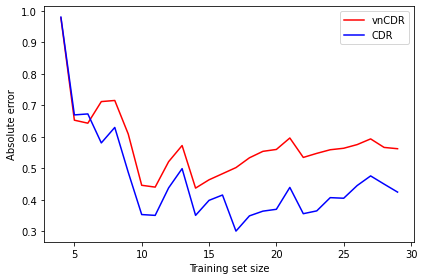

In [402]:
plt.figure(2)
plt.plot(M_list,vnCDR_list,label = 'vnCDR', color = 'red')
plt.plot(M_list, CDR_list, label = 'CDR', color = 'blue')
plt.legend()
plt.ylabel('Absolute error')
plt.xlabel('Training set size')
plt.tight_layout()
plt.show()

Convergence is observed with training set size. In general the CDR method converges more slowly. When converged both regression methods show an improvement over linear ZNE, but their performance is very similar. Due to the training set construction method, the convergence observed can be very quick or more slow, depending on how lucky one gets when completeing the Clifford projections. It can also be quite discontinous without doing any repeats, so the above graph may appear a little odd.

We should also see some convergence with the number of non-Cliffords.